## Imports

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import copy, math
import warnings
warnings.filterwarnings("ignore", message="The figure layout has changed to tight", category=UserWarning)

In [302]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


* bmi - Body Mass Index

## Data Analysis and Encoding

In [303]:
data.shape

(1338, 7)

In [304]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [305]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

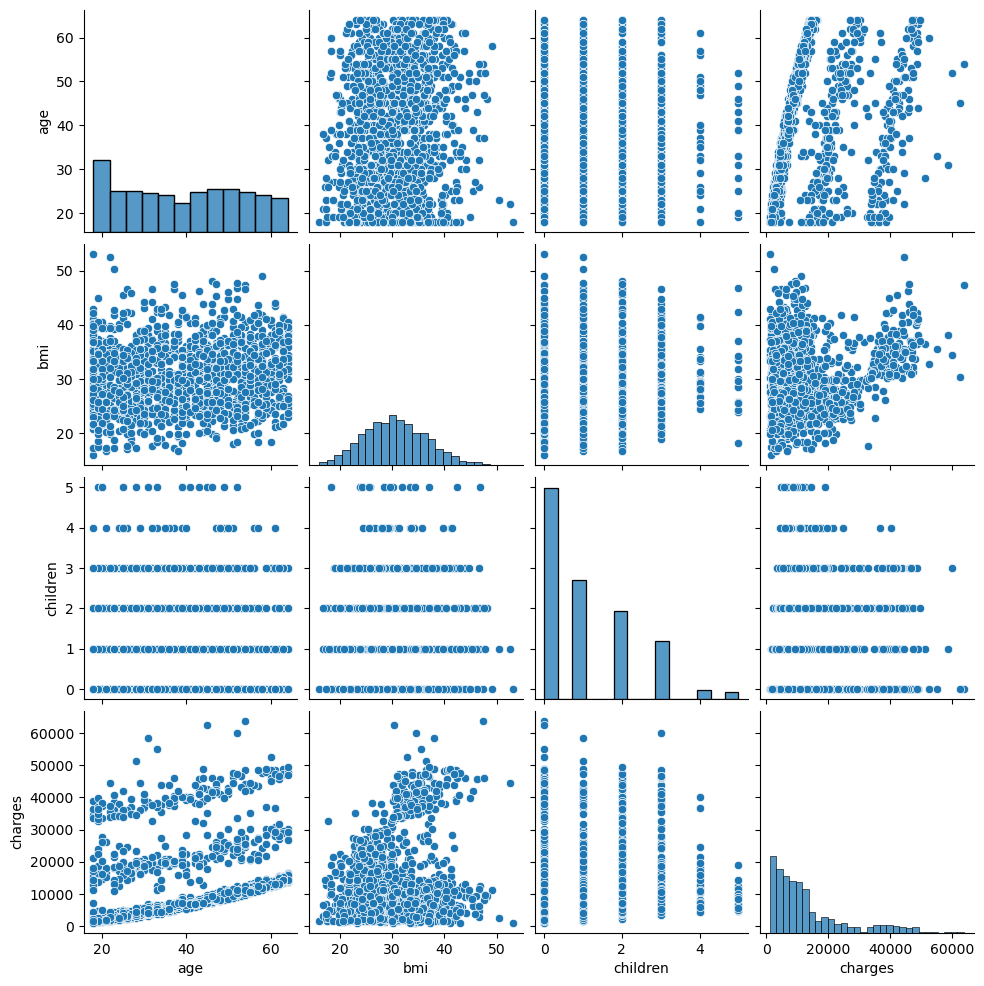

In [306]:
sns.pairplot(data)

**We can tell that there's no linear correlation between data**

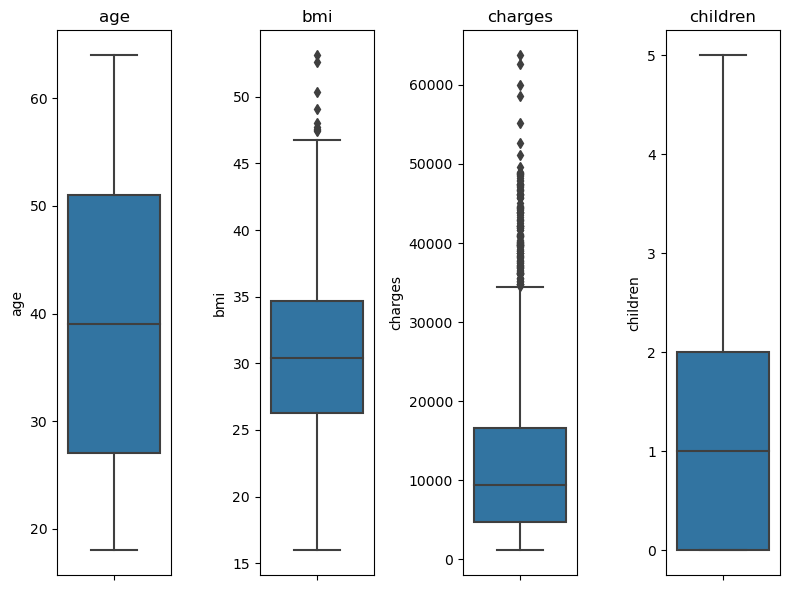

In [307]:
columns_to_plot = ['age', 'bmi', 'charges','children'] 

plt.figure(figsize=(8, 6))

for i, column in enumerate(columns_to_plot):
    plt.subplot(1, len(columns_to_plot), i+1)
    sns.boxplot(y=data[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [363]:
#What is the range of charges, age and bmi

max_age = data['age'].max()
min_age = data['age'].min()
max_bmi = data['bmi'].max()
min_bmi = data['bmi'].min()
max_charges = data['charges'].max()
min_charges = data['charges'].min()

print(f"Age: {min_age}-{max_age}")
print(f"BMI: {min_bmi}-{max_bmi}")
print(f"Charges: {round(min_charges)}-{round(max_charges)}")

Age: 18-64
BMI: 15.96-53.13
Charges: 1122-63770


**Provided box plots suggest that there are outliers in the bmi(aprox.47+) and in charges. I will remove those data values from the dataset**

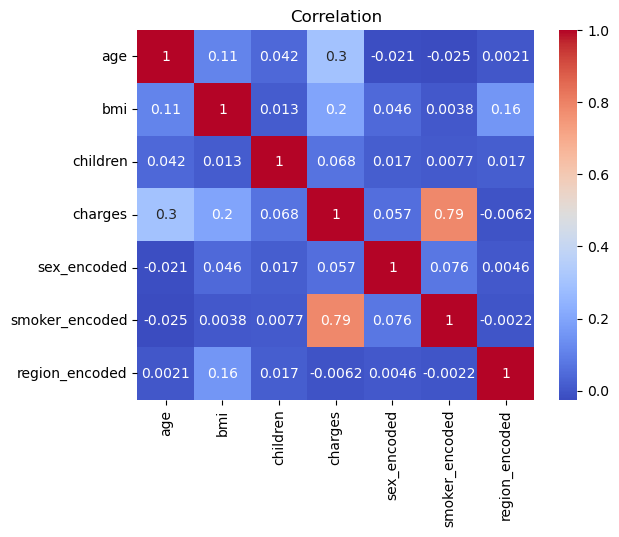

In [349]:
# Encoding categorical data
columns_to_encode = ['sex','smoker', 'region']

data_encoded = data.copy()
label_encoders = {}

for col in columns_to_encode:
    label_encoders[col] = LabelEncoder()
    data_encoded[col + '_encoded'] = label_encoders[col].fit_transform(data[col])
data_encoded = data_encoded.drop(columns_to_encode, axis=1)
data_encoded.corr()


sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation')
plt.show()

**The correlation is present only between smoking and charges. Correlation is strong positive (=0.79)**

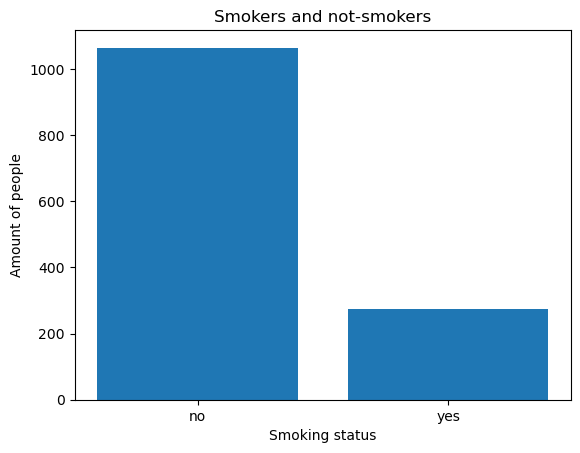

In [355]:
# Let's see what is the proportion of smokers and not-smoekrs
smoking_group = data.smoker.value_counts()

plt.bar(smoking_group.index, smoking_group.values)
plt.title("Smokers and not-smokers")
plt.xlabel('Smoking status')
plt.ylabel('Amount of people')
plt.show()

**Obviously in the dataset we have more people who do not smoke.
Also, since smoking has the strong correlation with charges, let's investigate into smoking and gender and bmi**

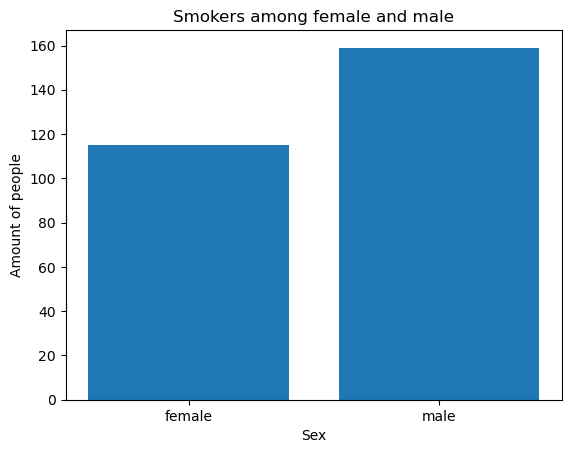

In [356]:
# Smokers among female and male
smokers_positive = data[data['smoker'] == 'yes']
smoking_gender = smokers_positive.groupby('sex').size().reset_index(name='count')

plt.bar(smoking_gender['sex'],smoking_gender['count'])
plt.title("Smokers among female and male")
plt.xlabel('Sex')
plt.ylabel('Amount of people')
plt.show()

**There's not much differance between the amount of smoking men and women, but nevertheless men smokers is a slightly larger group.**

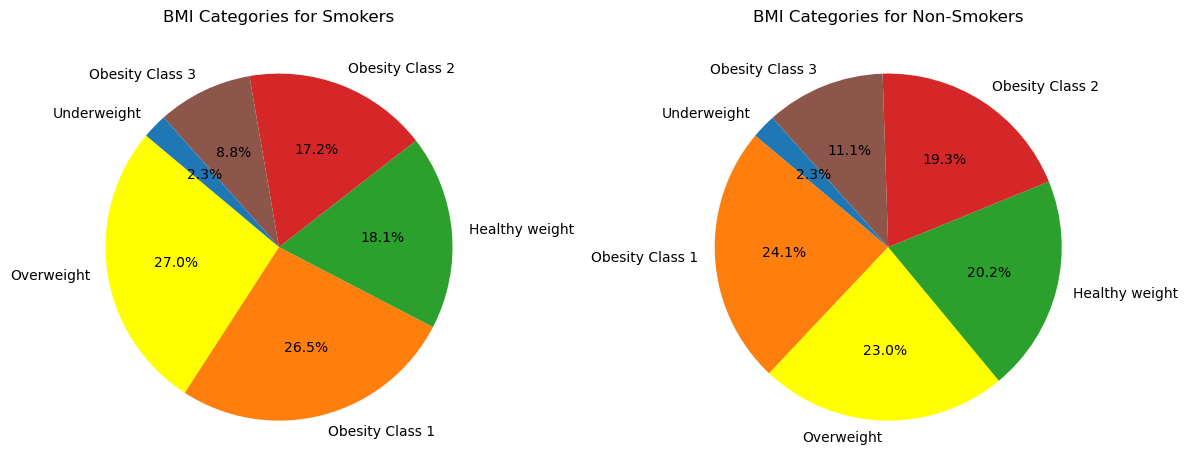

In [357]:
# Smoking and BMI
smokers_negative = data[data['smoker'] == 'no']
smoking_bmi = smokers_positive['bmi'].value_counts()
not_smoking_bmi = smokers_negative['bmi'].value_counts()

categories = {
    'Underweight': (float('-inf'), 18.5),
    'Healthy weight': (18.5, 25),
    'Overweight': (25, 30),
    'Obesity Class 1': (30, 35),
    'Obesity Class 2': (35, 40),
    'Obesity Class 3': (40, float('inf'))
}

def assign_category(bmi):
    for category, (lower, upper) in categories.items():
        if lower <= bmi < upper:
            return category

bmi_categories_smokers = smoking_bmi.index.map(assign_category)
bmi_categories_counts_smokers = bmi_categories_smokers.value_counts()

bmi_categories_not_smokers = not_smoking_bmi.index.map(assign_category)
bmi_categories_counts_not_smokers = bmi_categories_not_smokers.value_counts()

sorted_index_smokers = bmi_categories_counts_smokers.index.sort_values()
sorted_index_not_smokers = bmi_categories_counts_not_smokers.index.sort_values()

total_smokers = bmi_categories_counts_smokers.sum()
percentages_smokers = (bmi_categories_counts_smokers / total_smokers) * 100
total_not_smokers = bmi_categories_counts_not_smokers.sum()
percentages_not_smokers = (bmi_categories_counts_not_smokers / total_not_smokers) * 100

colors = {
    'Underweight': 'tab:blue',
    'Healthy weight': 'tab:green',
    'Overweight': 'yellow',
    'Obesity Class 1': 'tab:orange',
    'Obesity Class 2': 'tab:red',
    'Obesity Class 3': 'tab:brown'
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart for smokers
axes[0].pie(percentages_smokers, labels=percentages_smokers.index, autopct='%1.1f%%', startangle=140, colors=[colors[x] for x in percentages_smokers.index])
axes[0].set_title('BMI Categories for Smokers')

# Plot pie chart for non-smokers
axes[1].pie(percentages_not_smokers, labels=percentages_not_smokers.index, autopct='%1.1f%%', startangle=140, colors=[colors[x] for x in percentages_not_smokers.index])
axes[1].set_title('BMI Categories for Non-Smokers')

plt.tight_layout()
plt.show()

**I devided all BMI into 6 categories according to [CDC](https://www.cdc.gov/obesity/basics/adult-defining.html).**

**We can observe that the number of individuals with obesity class 1 and overweight is higher among smokers, while individuals with a healthy weight are more prevalent among non-smokers.**

## Data normalization

In [312]:
# We will proceed with encoded data, let's take a look at it once again.
data_encoded.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_encoded
0,19,27.900,0,16884.92400,0,1,3
1,18,33.770,1,1725.55230,1,0,2
2,28,33.000,3,4449.46200,1,0,2
3,33,22.705,0,21984.47061,1,0,1
4,32,28.880,0,3866.85520,1,0,1


In [313]:
# Capping high BMI values and Charges - removing outlayers

filtered_data = data_encoded[(data_encoded['bmi'] <= 47) & (data_encoded['charges'] <= 435000)]
x = filtered_data.drop(columns=['charges'])
# Convert input features to arrays
y = filtered_data['charges'].values

# Normalization method - dividing by max value of the array
x['age'] = x['age'] / x['age'].max()
x['bmi'] = x['bmi'] / x['bmi'].max()

# Convert input features to arrays
x_normalized = x.values

**Since our data values ranges (Age: 18-64, BMI: 15.96-53.13) we need to normalize the data. This can help gradient descent work faster.**

## Model generation

In [314]:
print("Shape of x_normalized:", x_normalized.shape)
print("Shape of y:", y.shape)

Shape of x_normalized: (1329, 6)
Shape of y: (1329,)


In [315]:
# At first we split our dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.2, random_state=42)

# Defining initial w value
w_init = np.zeros(x_normalized.shape[1])

### A little bit of math

In [316]:
# Cost function which we will want to minimize

def cost_function(x,y,w,b):
    m = x.shape[0]
    predictions = x.dot(w) + b
    cost = np.sum((predictions - y) ** 2) / (2 * m)
    return cost

# To find the minimum of the cost function we need to know in what direction we should move. For that -
# we will find derivatives of w and b (gradient)

def gradient_function(x,y,w,b):
    m = x.shape[0]
    predictions = x.dot(w) + b
    error = predictions - y
    dj_dw = x.T.dot(error) / m
    dj_db = np.sum(error) / m
    return dj_dw, dj_db

# Now we use gradient descent which will allow us to find the minimum value of cost function.
# From the previous function we know in what direction to move, now we need to know the step size (learning rate alpha)

def gradient_descent(x,y,w_in,b_in,compute_cost,compute_gradient, alpha,num_iter):
    J_history=[]
    w=copy.deepcopy(w_in)
    b=b_in
    
    for i in range (num_iter):
        dj_dw, dj_db = compute_gradient(x,y,w,b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        
        if i % math.ceil(num_iter/10) == 0:
            cost = compute_cost(x, y, w, b)
            J_history.append(cost)
            print(f"Iteration: {i:4d}. Cost: {cost:8.2f}")
    return w,b,J_history

### Final w and b

In [341]:
# We can change the alpha (learning rate) and number of iterations

initial_w = np.zeros(x_train.shape[1])
initial_b = 0.0
iterations = 10000
alpha =  0.109

w_final, b_final, J_hist = gradient_descent(x_train, y_train, initial_w, initial_b, cost_function, gradient_function,alpha, iterations)
print(f"Final w: {w_final}, final b: {b_final:0.2f}")

Iteration:    0. Cost: 83726431.24
Iteration: 1000. Cost: 18383259.86
Iteration: 2000. Cost: 18198378.52
Iteration: 3000. Cost: 18181692.71
Iteration: 4000. Cost: 18180176.03
Iteration: 5000. Cost: 18180038.16
Iteration: 6000. Cost: 18180025.63
Iteration: 7000. Cost: 18180024.49
Iteration: 8000. Cost: 18180024.39
Iteration: 9000. Cost: 18180024.38
Final w: [16408.24549688 15373.47436301   527.17858391  -117.0096303
 23621.63435523  -450.90808066], final b: -11547.53


## Model predictions and results

In [342]:
# We will use test data to make predictions

m, _ = x_test.shape
predictions = []
target_values = []

for i in range(m):
    print(f"prediction: {np.dot(x_test[i], w_final) + b_final:0.2f}, target value: {y_test[i]}")
    prediction = np.dot(x_test[i], w_final) + b_final
    target_value = y_test[i]
    predictions.append(prediction)
    target_values.append(target_value)

predictions = np.array(predictions)
target_values = np.array(target_values)

prediction: 276.69, target value: 2117.33885
prediction: 13121.49, target value: 30259.99556
prediction: 1322.65, target value: 1708.0014
prediction: 7834.69, target value: 6455.86265
prediction: 4235.92, target value: 4133.64165
prediction: 9057.42, target value: 27117.99378
prediction: 5664.72, target value: 3227.1211
prediction: 1715.41, target value: 2731.9122
prediction: 39817.60, target value: 47896.79135
prediction: 13651.95, target value: 13352.0998
prediction: 37700.18, target value: 44641.1974
prediction: 28723.43, target value: 19521.9682
prediction: 7400.29, target value: 3935.1799
prediction: 32387.41, target value: 38709.176
prediction: 5243.32, target value: 3947.4131
prediction: 8378.99, target value: 4320.41085
prediction: 10401.49, target value: 8162.71625
prediction: 8382.91, target value: 8891.1395
prediction: 9241.48, target value: 11013.7119
prediction: 28348.73, target value: 17179.522
prediction: 227.10, target value: 2103.08
prediction: 10294.25, target value: 

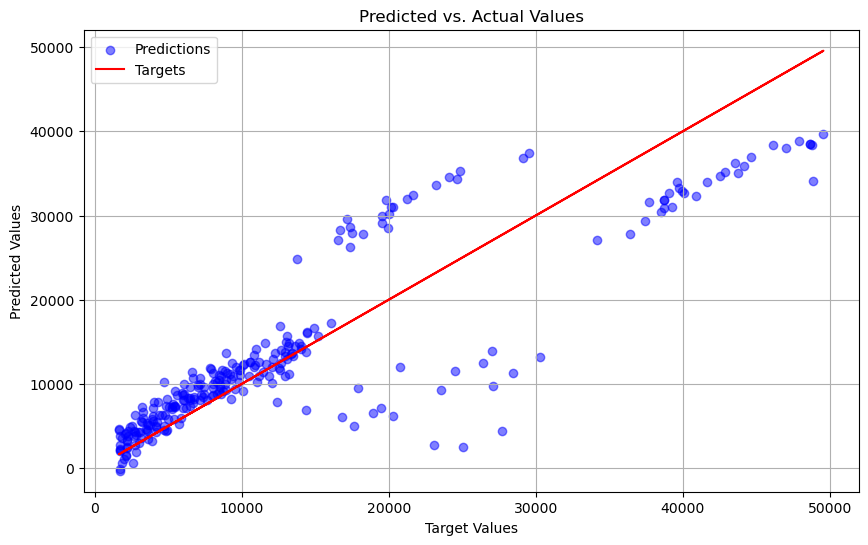

In [319]:
# Let's plot the predicted values against the target values
plt.figure(figsize=(10, 6))
plt.scatter(target_values, predictions, color='blue', alpha=0.5,label='Predictions')
plt.plot(target_values, target_values, color='red',label='Targets')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Target Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

- **We can see that many of the dots are close to the line, particularly for lower values, indicating that the model's predictions are reasonably accurate.**

- **The predictions seem to be more scattered as the target values increase. This could suggest that the model is less accurate for higher values. In other words, the model is more reliable at predicting lower values than higher ones.**

- **There are some dots that are far from the red line, which indicates outliers or instances where the model's predictions were significantly off. The reasons for these discrepancies could be underfitting (the model is too simple to capture complex patterns).**

In [343]:
# Measure such metrics as MAE and MSE 

predictions = np.dot(x_test, w_final) + b_final
absolute_differences = np.abs(predictions - y_test)
mae = np.mean(absolute_differences)
print(f'Mean Absolute Error (MAE): {round(mae,2)}')

predictions_2 = np.dot(x_test, w_final) + b_final
sq_differences = np.power((predictions_2 - y_test),2)
mse = np.mean(sq_differences)
print(f'Mean Squared Error (MSE): {round(mse,2)}')

Mean Absolute Error (MAE): 4099.66
Mean Squared Error (MSE): 34513463.07


In [344]:
# Measure R-squared score

def r_squared_score(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    return r_squared

predictions = np.dot(x_test, w_final) + b_final
r_squared = r_squared_score(y_test, predictions)

# Print R-squared score
print(f"R-squared score: {round(r_squared,2)}")

R-squared score: 0.77


- The **MAE** represents a significant portion of the range of charges, suggesting that **while the model has predictive capability, there is a noticeable average deviation between the predicted and actual values.**

- The Mean Squared Error (**MSE**) of 34,513,463.07 further indicates that there are **some predictions with substantial errors**, likely because the MSE is **sensitive to outliers** — individual predictions that are far from the actual values.

- An **R-squared score** of 0.77 in this context means that the **model explains 77% of the variability in insurance charges, which is relatively high**. However, given the magnitude of the errors (MAE and MSE), it's important to consider whether the model's predictions are precise enough for the intended use case. In the field of insurance, accurate predictions are crucial for setting premiums and managing risk.

# Summary
In summary, the model is capturing a substantial amount of the pattern in the data but also leaves room for improvement, particularly in reducing the prediction error. The MAE suggests that there may be a need for more nuanced modeling, perhaps taking into account additional features that could better capture the variance in insurance charges and/or considering another (more complex) algorithm (such as polynimoal regression or desicion tree).

# Using Sklearn

**In order to practise and compare my manually defined model, I used sklearn Linear Regression.**

In [345]:
# Imports and model creatiion
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [346]:
# Finding w and b

w = model.coef_
b = model.intercept_

print(f'y = {w[0]}x + {b}')

y = 16408.2502493702x + -11547.603228709897


In [347]:
# Making predictions

y_pred = model.predict(x_test)

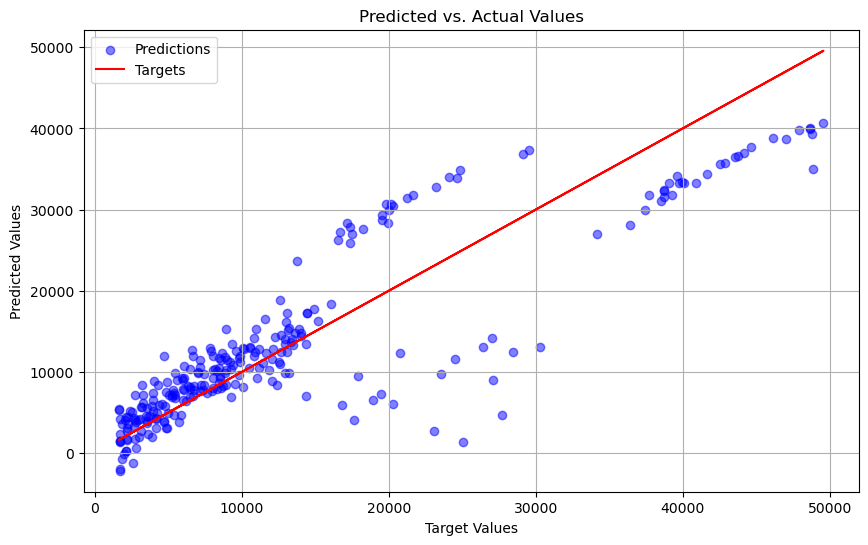

In [325]:
#Plotting thr results

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5,label='Predictions')
plt.plot(y_test, y_test, color='red',label='Targets')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Target Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

**The model from sklearn showed the same prediction as manual model.**

In [348]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_sl = mean_absolute_error(y_test, y_pred)
mse_sl = mean_squared_error(y_test, y_pred)
r2_sl = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {round(mae_sl,2)}')
print(f'Mean Squared Error (MSE): {round(mse_sl,2)}')
print(f'R-squared score: {round(r2_sl,2)}')

Mean Absolute Error (MAE): 4099.67
Mean Squared Error (MSE): 34513457.17
R-squared score: 0.77


**The sklearn model has the same metrics as manually-defined model.**